# 2022-09-30 • Use parametric STA model for connection testing

## Imports

In [1]:
#

In [2]:
using MyToolbox

In [3]:
using VoltoMapSim

# Note that we've consolidated code from the last model-fitting notebook
# in this codebase (namely in `src/conntest/model_STA.jl`).

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



## Params

In [4]:
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1,
    g_EI = 1,
    g_IE = 4,
    g_II = 4,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1:40; 801:810],
);

## Load STA's

(They're precalculated).

In [5]:
out = cached_STAs(p);

Loading cached output from `C:\Users\tfiers\.phdcache\calc_all_STAs\b9353bdd11d8b8cb.jld2` … done (14.5 s)


In [6]:
(ct, STAs, shuffled_STAs) = out;

In [7]:
# `ct`: "connections to test table", or simply "connections table".

## Test single

In [8]:
MSE(y, yhat) = mean(abs2, y .- yhat);
# We don't use the regression definition of `mse` in LsqFit.jl,
# where they devide by DOF (= num_obs - num_params) instead of num_obs.

In [9]:
function get_predtype(pval, Eness, α)
    # Eness is 'excitatory-ness'
    if        (pval  > α) predtype = :unconn
    elseif    (Eness > 0) predtype = :exc
    else                  predtype = :inh end
    predtype
end;

In [50]:
function test_conn__model_STA(real_STA, shuffled_STAs, α; p::ExpParams)
    fitted_params = fit_STA(real_STA, p)
    fitted_model = model_STA(p, fitted_params)
    test_stat(STA) = - MSE(fitted_model, centre(STA))
    pval, _ = calc_pval(test_stat, real_STA, shuffled_STAs)
    scale = fitted_params.scale / mV
    predtype = get_predtype(pval, scale, α)
    return (; predtype, pval, MSE = test_stat(real_STA), scale)
end;

In [10]:
α = 0.05 
conns = ct.pre .=> ct.post
example_conn(typ) = conns[findfirst(ct.conntype .== typ)]
testconn(conn) = test_conn__model_STA(STAs[conn], shuffled_STAs[conn], α; p)
conn = example_conn(:exc)

139 => 1

In [72]:
testconn(conn)

(predtype = :exc, pval = 0.01, MSE = -6.43E-09, scale = 0.357)

In [73]:
conn = example_conn(:inh)

988 => 1

In [74]:
testconn(conn)

(predtype = :inh, pval = 0.01, MSE = -4.81E-09, scale = -0.39)

In [75]:
conn = example_conn(:unconn)

23 => 1

In [76]:
testconn(conn)

(predtype = :inh, pval = 0.01, MSE = -7.8E-09, scale = -0.268)

Yeah this obviously won't work: the MSE of the STA used for fitting will always be better than the MSE of other STAs -- even if the real STA is unconnected.

What is fit btw of this last one

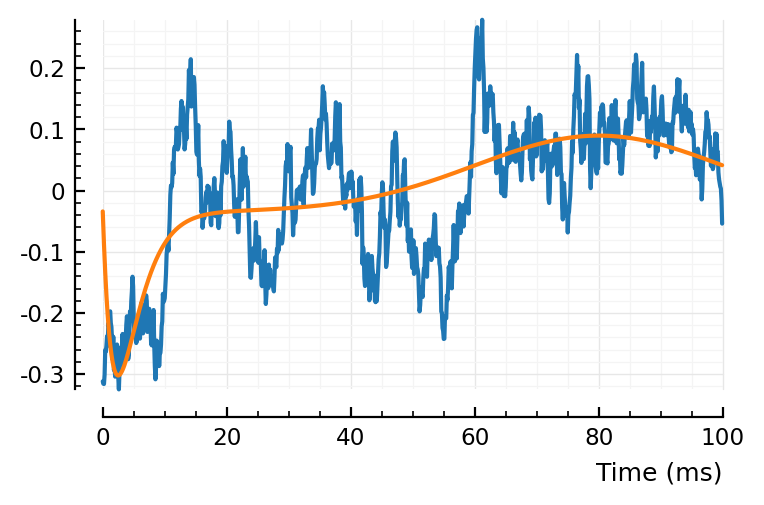

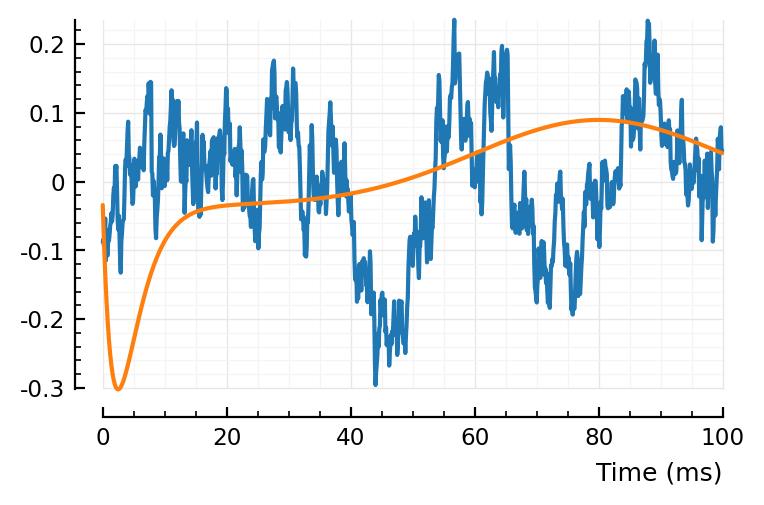

In [65]:
real_STA = STAs[conn]
fitted_params = fit_STA(real_STA, p)
fitted_model = model_STA(p, fitted_params)
plotsig(centre(real_STA) / mV, p)
plotsig(fitted_model / mV, p);
plt.subplots()
plotsig(centre(shuffled_STAs[conn][1]) / mV, p)
plotsig(fitted_model / mV, p);

(real STA left, one of the shuffled STAs right).

Let's see how bad it is for all connections:

In [77]:
# tc = test_conns(test_conn__model_STA $ (;p), ct, STAs, shuffled_STAs; α = 0.05);

^ This is too slow to run fully.

And there's an error when fitting `813 => 1`.

How slow?

In [81]:
@time testconn(conn);

  0.468124 seconds (129.11 k allocations: 614.167 MiB, 6.55% gc time)


In [83]:
ETA = 0.468124seconds * length(conns) / minutes

30.5

Imagine if we fit all shuffles (which would work ig).
For all our tested connections, we'd have to wait:

In [85]:
ETA * (1+p.conntest.num_shuffles) * minutes / hours

51.3

4+ days. A bit long.

Let's subsample the connections, to get some estimate for how bad performance is.

## Test sample

In [15]:
samplesize = 100
resetrng!(1234)
i = sample(1:nrow(ct), samplesize, replace = false)
ctsample = ct[i, :];

In [16]:
summarize_conns_to_test(ctsample)

We test 100 putative input connections to 45 neurons.
32 of those connections are excitatory, 15 are inhibitory, and the remaining 53 are non-connections.


(I forgot to resetrng at first run. Tables below are for below sample:
```
We test 100 putative input connections to 42 neurons.
34 of those connections are excitatory, 13 are inhibitory, and the remaining 53 are non-connections.
```
)

We have to fix that occasional fitting error too, first.

In [116]:
testconn(917 => 8)   # Gives `InexactError: trunc(Int64, NaN)`
# (which I could step-debug in jupyter; I'll go to vscode, and use the .jl version of this nb).

# reason for error: `tx_delay / Δt` is somehow NaN.

# ~~Fixed when lower pound for tx_delay = 1 ms, instead of 0. Strange.~~
# Even then it errored for other conns. Manually checked for NaN tx_delay in model function.
# That actually fixed it.

(predtype = :inh, pval = 0.01, MSE = -6.65E-08, scale = -1.82)

In [128]:
@time tc = test_conns(test_conn__model_STA $ (;p), ctsample, STAs, shuffled_STAs; α = 0.05);

Testing connections: 100%|██████████████████████████████| Time: 0:00:39
 39.690764 seconds (23.44 M allocations: 54.926 GiB, 7.34% gc time)


In [132]:
# strange. it somehow swallows output?
# but if I copy the cell (or add a `@show` in the loop), the output shows.
# just copy it, in jupyter, no execution! weird.

In [133]:
perftable(tc)

Tested connections: 100,,,,,,
,,┌───────,Real type,───────┐,,Precision
,,unconn,exc,inh,,
┌,unconn,19,1,3,,83%
Predicted type,exc,22,32,0,,59%
└,inh,12,1,10,,43%
,,,,,,
Sensitivity,,36%,94%,77%,,


So detection rates not bad, but low precision, and 64% false positive rate for non-connections.

In [134]:
1-.36

0.64

At least we had some with pval > 0.05, I would've expected all unconn's to be detected.

## Try proper test

..where we fit every shuffle as well.
This will be very slow, so we do it on just one connection, to get an idea if it's worth pursuing (and speeding up, via automatic differentiation of our model STA, maybe).

This is what we got above:

In [137]:
conn = example_conn(:unconn)

23 => 1

In [138]:
testconn(conn)

(predtype = :inh, pval = 0.01, MSE = -8.16E-09, scale = -0.264)

i.e. pval 0.01.

With template matching, we get pval 0.42 ([ref](https://tfiers.github.io/phd/nb/2022-09-09__Conntest_with_template_matching.html#now-for-unconnected-inputs)).
So it is definitely predictable as unconnected.

In [145]:
function test_conn__model_STA__proper(real_STA, shuffled_STAs, α; p::ExpParams)
    function test_stat(STA)
        print(".")  # hack to progress-track
        fitted_params = fit_STA(STA, p)
        fitted_model = model_STA(p, fitted_params)
        t = - MSE(fitted_model, centre(STA))
    end
    pval, _ = calc_pval(test_stat, real_STA, shuffled_STAs)
    scale = fit_STA(real_STA, p).scale / mV
    predtype = get_predtype(pval, scale, α)
    return (; predtype, pval, scale)
end

testconn2(conn) = test_conn__model_STA__proper(STAs[conn], shuffled_STAs[conn], 0.05; p);

In [146]:
testconn2(conn)

.....................................................................................................

(predtype = :unconn, pval = 0.56, scale = -0.264)

Aha! That looks good.

Now for the example exc and inh of above.

In [147]:
testconn2(example_conn(:exc))

.....................................................................................................

(predtype = :unconn, pval = 0.91, scale = 0.357)

In [148]:
testconn2(example_conn(:inh))

.....................................................................................................

(predtype = :unconn, pval = 0.94, scale = -0.39)

That's no good.

In [57]:
function plot_with_fit(STA, fitparams; kw...)
    fitted_model = model_STA(p, fitparams)
    plt.subplots()
    plotsig(centre(STA) / mV, p; kw...)
    plotsig(fitted_model / mV, p)
end;

In [18]:
function fit_and_plot(STA)
    fitted_params = fit_STA(STA, p)
    fitted_model = model_STA(p, fitted_params)
    rmse = √MSE(fitted_model, centre(STA)) / mV
    title = "RMSE: " * @sprintf "%.3f mV" rmse
    ylim = [-0.25, 0.35]
    plot_with_fit(STA, fitted_params; ylim, title)
end;

In [206]:
conn = example_conn(:exc)

139 => 1

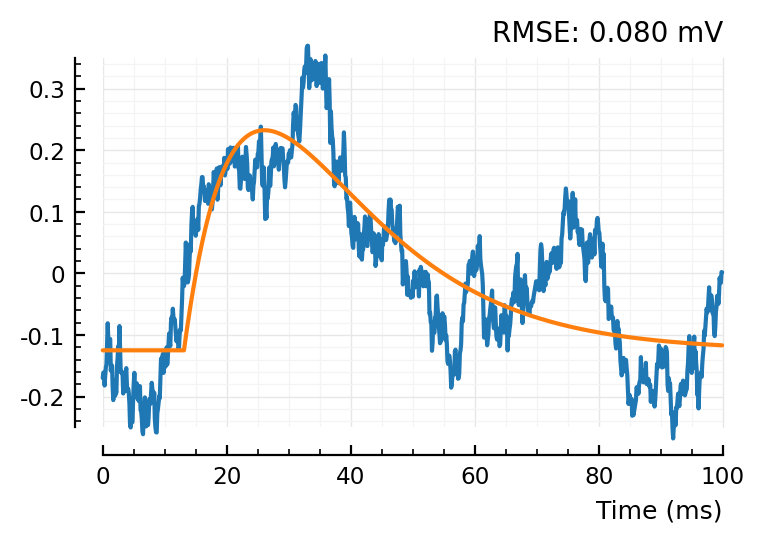

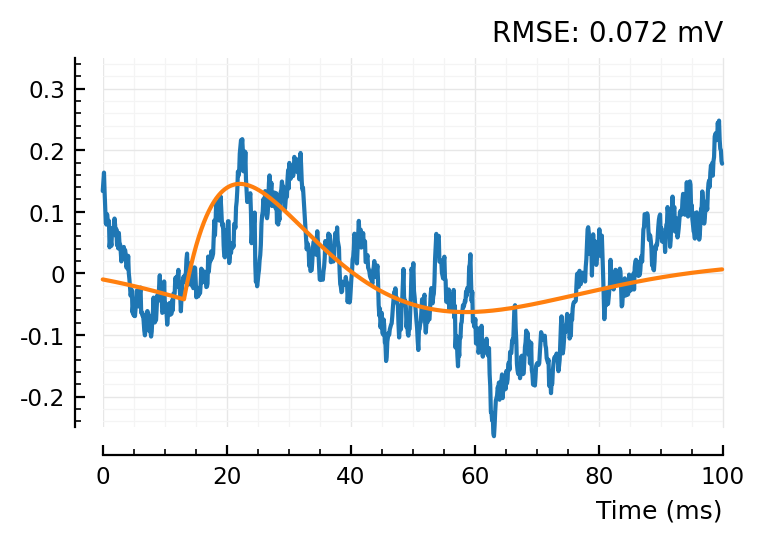

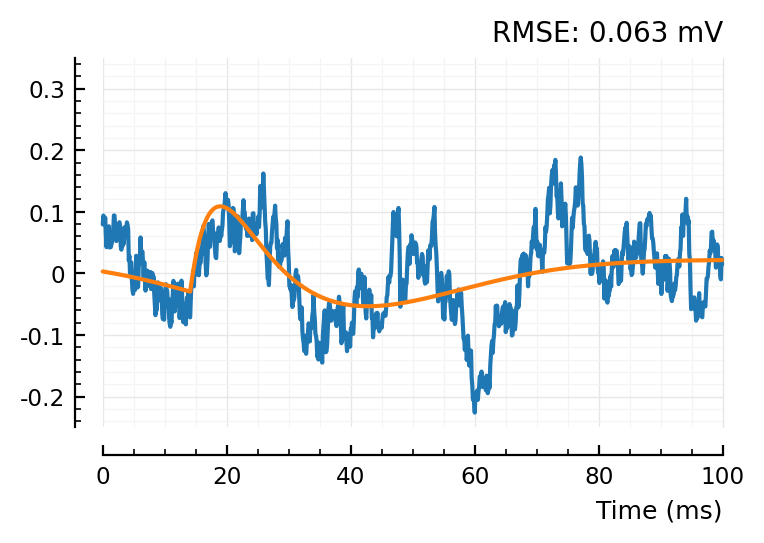

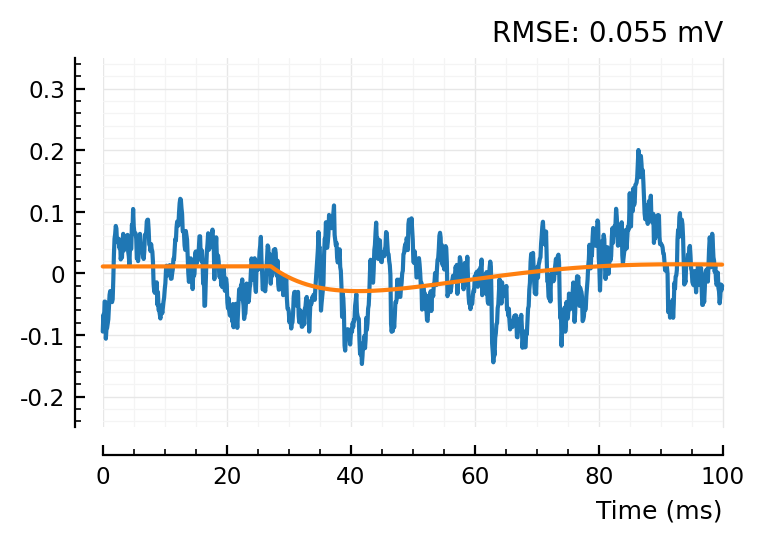

In [207]:
fit_and_plot(STAs[conn])
fit_and_plot(shuffled_STAs[conn][1])
fit_and_plot(shuffled_STAs[conn][2])
fit_and_plot(shuffled_STAs[conn][3]);

So the shuffleds have a better MSE.. but that's because their scale is narrower.

We'll normalize before calculating mse:

In [377]:
function test_conn__model_STA__proper2(real_STA, shuffled_STAs, α; p::ExpParams)
    function test_stat(STA)
        print(".")  # hack to progress-track
        fitted_params = fit_STA(STA, p)
        fitted_model = model_STA(p, fitted_params)
        zscore(x) = (x .- mean(STA)) ./ std(STA)
        t = - MSE(zscore(fitted_model), zscore(STA))
    end
    pval, _ = calc_pval(test_stat, real_STA, shuffled_STAs)
    println()
    scale = fit_STA(real_STA, p).scale / mV
    predtype = get_predtype(pval, scale, α)
    return (; predtype, pval, scale)
end

testconn3(conn) = test_conn__model_STA__proper2(STAs[conn], shuffled_STAs[conn], 0.05; p);

In [172]:
testconn3(example_conn(:unconn))

.....................................................................................................

(predtype = :unconn, pval = 0.35, scale = -0.264)

In [173]:
testconn3(example_conn(:exc))

.....................................................................................................

(predtype = :exc, pval = 0.01, scale = 0.357)

In [174]:
testconn3(example_conn(:inh))

.....................................................................................................

(predtype = :inh, pval = 0.01, scale = -0.39)

Alright! This seems to work.

## Try autodiff for speedup

In [175]:
conn

139 => 1

It's hard to get ForwardDiff.jl to work with ComponentArrays.jl and @unpack.
(might be possible). But simpler to re-write model func, more 'basic':

In [11]:
Δt = p.sim.general.Δt::Float64
STA_duration = p.conntest.STA_window_length
t = collect(linspace(0, STA_duration, STA_win_size(p)))

linear_PSP(t, τ1, τ2) =
    if (τ1 == τ2)   @. t * exp(-t/τ1)
    else            @. τ1*τ2/(τ1-τ2) * (exp(-t/τ1) - exp(-t/τ2)) end

gaussian(t, loc, width) =
    @. exp(-0.5*( (t-loc)/width )^2)

rescale_to_max!(x) =
    x ./= maximum(abs.(x))

function model_(t, params)
    tx_delay, τ1, τ2, dip_loc, dip_width, dip_weight, scale = params
    bump = linear_PSP(t .- tx_delay, τ1, τ2)
    tx_size = round(Int, tx_delay / Δt)
    bump[1:tx_size] .= 0
    rescale_to_max!(bump)
    dip = gaussian(t, dip_loc, dip_width)
    rescale_to_max!(dip)
    dip .*= -dip_weight
    STA_model = (bump .+ dip) .* scale
    STA_model .-= mean(STA_model)
    return STA_model
end

p0_vec = collect(VoltoMapSim.p0)
lower, upper = VoltoMapSim.lower, VoltoMapSim.upper
function fit_(STA; autodiff = :finite)  # or :forwarddiff
    curve_fit(model_, t, centre(STA), p0_vec; lower, upper, autodiff)
end;

In [366]:
real_STA = STAs[conn]

@time fit_finite = fit_(real_STA; autodiff = :finite);  # default

  0.236855 seconds (64.51 k allocations: 301.317 MiB, 8.62% gc time)


Hah, our simpler function is also just faster with the default.

In [369]:
real_STA = STAs[conn]

@time fit_AD = fit_(real_STA; autodiff = :forwarddiff);

  0.058227 seconds (10.04 k allocations: 100.627 MiB, 11.74% gc time)


:DDD

Amazing.

Is the result correct though?

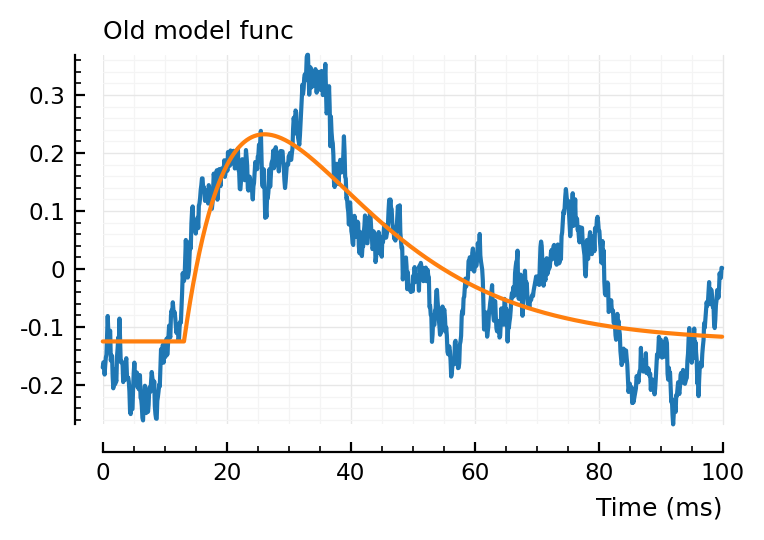

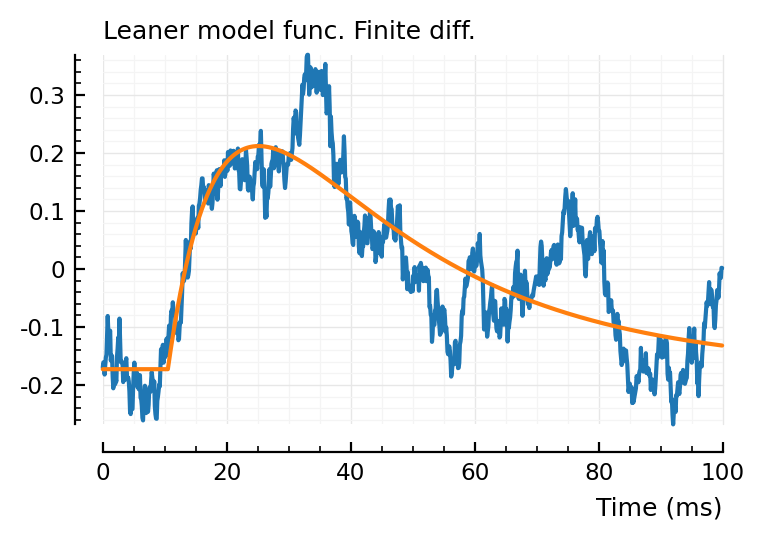

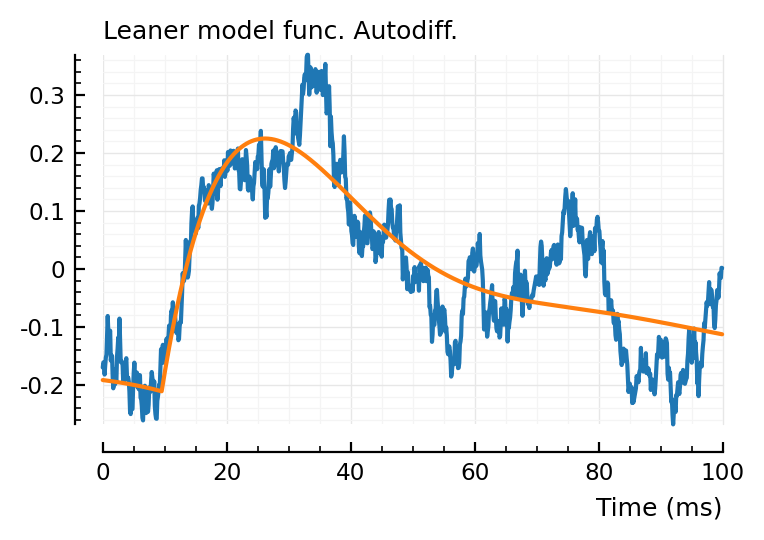

In [370]:
plot_with_fit(real_STA, fit_STA(real_STA, p), hylabel = "Old model func")
plot_with_fit(real_STA, fit_finite.param, hylabel = "Leaner model func. Finite diff.");
plot_with_fit(real_STA, fit_AD.param, hylabel = "Leaner model func. Autodiff.");

All three give a slightly different fit, interestingly.

Is there a diff between our two model functions, for the same params, btw?

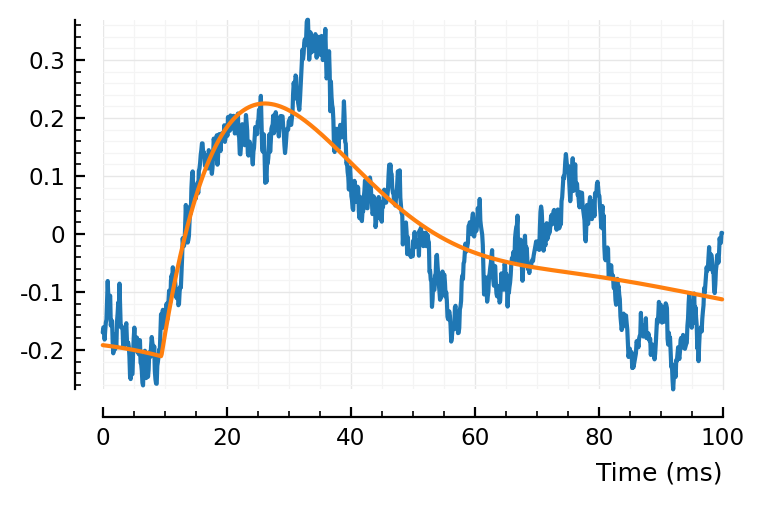

In [236]:
plt.subplots()
plotsig(centre(real_STA) / mV, p)
plotsig(model_(t, fit_AD.param) / mV, p);

No, nothing perceptible.

Now, use this model and AD fit for a proper conntest.

In [374]:
function test_conn__model_STA__proper_AD(real_STA, shuffled_STAs, α; p::ExpParams, verbose = true)
    function test_stat(STA)
        verbose && print(".")
        fit = fit_(STA, autodiff = :forwarddiff)
        fitted_model = model_(t, fit.param)
        zscore(x) = (x .- mean(STA)) ./ std(STA)
        return - MSE(zscore(fitted_model), zscore(STA))
    end
    pval, _ = calc_pval(test_stat, real_STA, shuffled_STAs)
    verbose && println()
    scale = fit_STA(real_STA, p).scale / mV
    predtype = get_predtype(pval, scale, α)
    return (; predtype, pval, scale)
end

testconn4(conn) = test_conn__model_STA__proper_AD(STAs[conn], shuffled_STAs[conn], 0.05; p);

Are the pval results the same on our three examples?

In [373]:
testconn4(example_conn(:unconn))

.....................................................................................................

(predtype = :unconn, pval = 0.35, scale = -0.268)

Was also 0.35 above.

In [234]:
testconn4(example_conn(:exc))

.....................................................................................................

(predtype = :exc, pval = 0.01, scale = 0.357)

In [235]:
testconn4(example_conn(:inh))

.....................................................................................................

(predtype = :inh, pval = 0.01, scale = -0.39)

Same pvals (and same scales).

Btw. Can we speedup more by calculating the jacobian beforehand, once?

In [239]:
# ] add ForwardDiff

..wait no. ForwardDiff api has just `jacobian(f,x)`, which is the jac evaluated at a specific point.
No general `jacobian(f)` function.

Another speedup might be achieved by using non-allocating (i.e. in-place, i.e. buffer-overwriting) model functions: https://github.com/JuliaNLSolvers/LsqFit.jl#in-place-model-and-jacobian

In [376]:
@time testconn4(example_conn(:inh));

.....................................................................................................
 10.903671 seconds (1.98 M allocations: 17.263 GiB, 11.85% gc time)


So testing one connection, the 'proper' way, is now 11 seconds.

Compare before AD (and before leaner model func):

In [379]:
@time testconn3(example_conn(:inh));

.....................................................................................................
 49.033385 seconds (27.78 M allocations: 64.933 GiB, 9.67% gc time)


So 49/10.9 = 4.5x speedup through AD.

Testing our sample of 100 connections would take 18 minutes.

Let's try a non-allocating model func.

## In-place model & jacobian

We cannot combine in-place with ForwardDiff by default: https://github.com/JuliaDiff/ForwardDiff.jl/issues/136

We need https://github.com/SciML/PreallocationTools.jl

We only need it only for our bump and dip buffers though, not for the output buffer:
that one is handled by ForwardDiff's in-place-model API (`jacobian(f!, y, x)`).

In [21]:
using PreallocationTools, ForwardDiff

In [305]:
linear_PSP!(y, t, τ1, τ2) =
    if (τ1 == τ2)   @. y = t * exp(-t/τ1)
    else            @. y = τ1*τ2/(τ1-τ2) * (exp(-t/τ1) - exp(-t/τ2)) end

gaussian!(y, t, loc, width) =
    @. y = exp(-0.5*( (t-loc)/width )^2)

rescale_to_max_!(x) =
    x ./= maximum(x)
    # Here we assume x positive, so `abs.(x)` (which allocates) is not needed.

function model_!(STA, t, params, dualcaches, Δt)
    # -- 
    # -- https://github.com/SciML/PreallocationTools.jl
    tc, bc, dc = dualcaches
    u = params[1]  # just to get type of input: Float or Dual
    tshift = get_tmp(tc, u)
    bump = get_tmp(bc, u)
    dip = get_tmp(dc, u)
    # --
    tx_delay, τ1, τ2, dip_loc, dip_width, dip_weight, scale = params
    tshift .= t .- tx_delay
    linear_PSP!(bump, tshift, τ1, τ2)
    tx_size = round(Int, tx_delay / Δt)
    bump[1:tx_size] .= 0
    rescale_to_max_!(bump)
    gaussian!(dip, t, dip_loc, dip_width)
    rescale_to_max_!(dip)
    dip .*= -dip_weight
    STA .= (bump .+ dip) .* scale
    STA .-= mean(STA)
    return nothing
end;

In [306]:
F0 = similar(t)
tc = dualcache(similar(t))
bc = dualcache(similar(t))
dc = dualcache(similar(t))
# For curve_fit api:
model_!(STA, t, params) = model_!(STA, t, params, (tc,bc,dc), Δt);  

In [309]:
y = similar(t)
model_!(y, t, p0_vec)
time() = @time model_!(y, t, p0_vec)
time();

  0.000048 seconds (1 allocation: 64 bytes)


In [252]:
f! = (F,p) -> model_!(F,t,p)

Jbuf = ForwardDiff.jacobian(f!, F0, p0_vec);

In [219]:
# For curve_fit api:
jac_model!(J, t, params) = ForwardDiff.jacobian!(J, f!, F0, params);

In [254]:
jac_model!(Jbuf, t, p0_vec)
time() = @time jac_model!(Jbuf, t, p0_vec)
time();

  0.000226 seconds (12 allocations: 251.656 KiB)


:OOO so few allocs 😁😁😁

In [235]:
@time curve_fit(model_!, jac_model!, t, real_STA, p0_vec; lower, upper, inplace = true);

  0.061003 seconds (5.22 k allocations: 46.477 MiB)


Hmm, that's lotsa allocs, and not much faster than non-inplace, it seems.

non-inplace:

In [355]:
@time curve_fit(model_, t, real_STA, p0_vec; lower, upper, autodiff = :forward);

  0.065619 seconds (10.04 k allocations: 100.619 MiB, 11.79% gc time)


Yeah. guess LsqFit.jl problem doesn't do inplace very well.


Let's test for full pval loop anyway.

In [381]:
fit_inplace(STA) = curve_fit(model_!, jac_model!, t, centre(STA), p0_vec; lower, upper, inplace = true);

fitted_model = similar(t)  # Buffer

function test_conn__model_STA__proper_AD_inplace(real_STA, shuffled_STAs, α; p::ExpParams, verbose = true)
    function test_stat(STA)
        verbose && print(".")
        fit = fit_inplace(STA)
        model_!(fitted_model, t, fit.param)
        zscore(x) = (x .- mean(STA)) ./ std(STA)
        return - MSE(zscore(fitted_model), zscore(STA))
    end
    pval, _ = calc_pval(test_stat, real_STA, shuffled_STAs)
    verbose && println()
    scale = fit_inplace(real_STA).param[end] / mV
    predtype = get_predtype(pval, scale, α)
    return (; predtype, pval, scale)
end

testconn5(conn) = test_conn__model_STA__proper_AD_inplace(STAs[conn], shuffled_STAs[conn], 0.05; p);

In [247]:
@time testconn5(example_conn(:inh));

.....................................................................................................
  8.942858 seconds (1.41 M allocations: 7.988 GiB, 7.23% gc time, 2.73% compilation time)


So yeah, same perf as the allocating, non-inplace version  
(11 seconds, 1.98 M allocations: 17.231 GiB)

In [257]:
# using ProfileView
# @profview testconn5(example_conn(:inh));

Annotated flamegraph (execution time profiling):

![](images/profile_curve_fit.png)
(open original for full size)

Conclusions from this profile:
- The gains by writing an in-place model function were negated by performance hit of that `get_tmp` function.
  (Hence why it was ~as fast as the previous, allocating model).
- I do not expect a big gain by writing a jacobian function manually: the `f` evaluation
  (right `model` 'tower' in the flamegraph) is almost as big as the `jac(f)` evaluation (left `model` tower).
    - In other words, automatic differentiation (ForwardDiff.jl) is magic.
- More generally: I do not expect substantial speedups are possible for this connection test method:
  Most time is already spent in the basic operations to construct our model (`exp`, `*`).
  Maybe a fitting algorithm that needs less function/jacobian evaluations.

To squeeze out all performance:
- `rescale_to_max` not needed: just divide by analytic expression for height of alpha-synpase and gaussian.
    - I'd wager one exists for the alpha-synapse, vaguely remember seeing one somewhere even.
    - (better than division: multiply by pre-calculated inverse)
- Only one extra buffer (besides the first arg) is needed (so only one costly `get_tmp()` call).
    - Maybe we can make a faster version of that dualcache, too
    - Actually maybe we don't need any: use first arg buffer `y` for `tshift`, then `linear_PSP!(y, y, τ1, τ2)`; then add the gaussian to it; etc.
- Provide that `JacobianConfig()` beforehand (if possible)
- I'd wager there's faster versions of `exp` available (and we can likely get away with a bit less precision).
    - We can try [`@fastmath`](https://docs.julialang.org/en/v1/base/math/#Base.FastMath.@fastmath), though must check whether results are still correct.
        - ah, it indeed uses `exp_fast`: [src](https://github.com/JuliaLang/julia/blob/master/base/fastmath.jl)
- Experiment with levenberg marquardt params & reporting: how many f/jac evals now? Can we get a good fit with fewer evaluations?

The above are quite easy. More difficult:
- Write manual jacobian (so ForwardDiff.jl machinery not needed).
    - Seems feasible. Can test correctness with autodiff (or finite differences).

## Use proper method, with autodiff, on sample

In [269]:
f = test_conn__model_STA__proper_AD $ (; p, verbose=false)

@time tc = test_conns(f, ctsample, STAs, shuffled_STAs; α = 0.05, pbar = false);

....................................................................................................1084.939439 seconds (201.36 M allocations: 1.734 TiB, 11.70% gc time, 0.09% compilation time: 82% of which was recompilation)


In [270]:
1085/minutes

18.1

1.7 TiB allocations 😄

In [271]:
# backup
tc_proper = tc;

In [272]:
perftable(tc)

Tested connections: 100,,,,,,
,,┌───────,Real type,───────┐,,Precision
,,unconn,exc,inh,,
┌,unconn,41,8,0,,84%
Predicted type,exc,5,26,0,,84%
└,inh,7,0,13,,65%
,,,,,,
Sensitivity,,77%,76%,100%,,


That's not bad!\
Comparing with the two-pass (ptp and corr) test of previous nb:

|Tested connections: 3906|&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |&nbsp; &nbsp; &nbsp; |&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |
|------------------|--------|------------|-------------|------------|-------|-------------|
|                  |        |**┌───────**|**Real type**|**───────┐**|       |**Precision**|
|                  |        |    `unconn`|        `exc`|       `inh`|       |             |
|             **┌**|`unconn`|        1704|          274|          25|       |          85%|
|**Predicted type**|   `exc`|         139|         1235|           0|       |          90%|
|             **└**|   `inh`|         157|            6|         366|       |          69%|
|                  |        |            |             |            |       |             |
|   **Sensitivity**|        |         85%|          82%|         94%|       |             |

Time comparison:
given precalculated STAs, the ptp-then-corr method takes about 10 seconds to test 3906 connections.
The curve fitting method takes 18 minutes for 100 connections.

In [260]:
(18minutes/100) / (10seconds/3906)

4.22E+03

4000x faster 😄

## Conclusion

In conclusion: connection-testing by curve-fitting a parametric STA model to the STAs (real and shuffled) seems to give respectable performance. However, it is multiple orders of magnitude slower than the ptp-then-corr method, taking 18 minutes to test 100 connections.

The advantage of the parametric curve-fitting is that it can handle different transmission delays and time scales per synapse, while the ptp-then-corr method might not.
(Though we haven't tested either assertion).

---

## [appendix]

### Squeezing out last drop of performance

Max of the gaussian func as I defined it is simply 1 (namely at `t = loc`).

Max of $t e^{-t/τ}$ is at $t = τ$, so: $τ/e$  


Max of $\frac{τ_1 τ_2}{τ_1 - τ_2} \left( e^{-t/τ_1} - e^{-t/τ_2} \right)$

is at $t = \frac{τ_1 τ_2}{τ_1 - τ_2} \log\left( \frac{τ_2}{τ_1} \right)$

evaluated: max = $τ_2 \left( \frac{τ_2}{τ_1} \right)^\frac{τ_2}{τ_1 - τ_2}$

([thanks wolfram](https://www.wolframalpha.com/input?i=d%2Fdt+%28+a*b%2F%28a-b%29+*+%28exp%28-t%2Fa%29+-+exp%28-t%2Fb%29%29+%29+%3D+0))

In [22]:
linear_PSP_fm!(y, t, τ1, τ2) =
    if (τ1 == τ2)   @. @fastmath y = t * exp(-t/τ1)
    else            @. @fastmath y = τ1*τ2/(τ1-τ2) * (exp(-t/τ1) - exp(-t/τ2)) end

function turbomodel!(y, t, params, Δt)
    tx_delay, τ1, τ2, dip_loc, dip_width, dip_weight, scale = params
    T = round(Int, tx_delay / Δt) + 1
    y[T:end] .= @view(t[T:end]) .- tx_delay    
    @views linear_PSP_fm!(y[T:end], y[T:end], τ1, τ2)
    if (τ1 == τ2) max = τ1/ℯ
    else          max = τ2*(τ2/τ1)^(τ2/(τ1-τ2)) end
    @views y[T:end] .*= (1/max)
    y[1:T-1] .= 0
    y .-= @. @fastmath dip_weight * exp(-0.5*( (t-dip_loc)/dip_width )^2)
    y .*= scale
    y .-= mean(y)
    return nothing
end;

Check if correct:

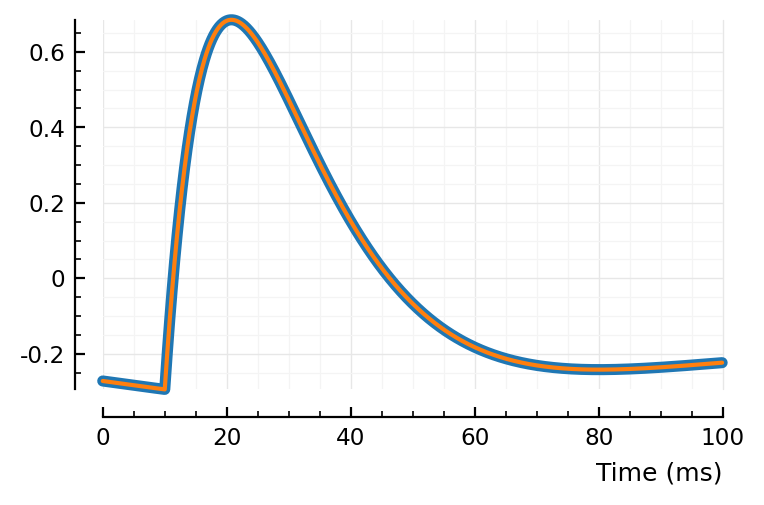

In [295]:
STA = similar(t)
p0_ = @set (p0_vec[end] = 1)
turbomodel!(STA, t, p0_, Δt)
STA_prev = model_(t, p0_)
plt.subplots()
plotsig(STA_prev, p, lw=4)
plotsig(STA, p);
# plotsig(1e5 * (STA .- STA_prev), p);

Yah that's the same

Comparison with previous in place model:

In [313]:
@benchmark model_!(y, t, p0_vec)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  22.600 μs … 233.500 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     28.000 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   29.567 μs ±   5.547 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁ ▂▂▃▄▃▅▅▄▇▄█▃▇▁▅ ▂ ▁▁▁▃▂▁▂▁ ▂  ▂  ▂▁  ▃   ▂                 ▂
  ███████████████████████████████▇██▇██▇▇███▇██▆▇▆▆▆▆▆▆▆▆▆▇▆▆▅ █
  22.6 μs       Histogram: log(frequency) by time      48.4 μs <

 Memory estimate: 64 bytes, allocs estimate: 1.

In [314]:
@benchmark turbomodel!(y, t, p0_vec, Δt)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  15.300 μs … 117.200 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     18.600 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   20.385 μs ±   4.746 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃▃▃▄▅▅▇▆▅█▆▅  ▅        ▅▁ ▁       ▆▄  ▂   ▂                  ▂
  ████████████▇███▆▇▇████████▇▇█▆▆▇▅██▇▅█▆▆▇█▆▆▇▇█▆▇▅▄▄▄▄▅▆▇▆▅ █
  15.3 μs       Histogram: log(frequency) by time      36.1 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

(Yay, got rid of last alloc).

Alright, so our last optims got us a 1.5x speedup.
-- for the Float case. When called with Duals (in the autodiff), it's probably faster still.
Let's try.

Also, let's see if we can prealloc and reuse the fwddiff "Config" object.

In [23]:
turbomodel!(y, t, params) = turbomodel!(y, t, params, Δt)
ft! = (y,p) -> turbomodel!(y, t, p)
y = similar(t)
cfg = ForwardDiff.JacobianConfig(ft!, y, p0_vec)
jac_turbomodel!(J, t, params) = ForwardDiff.jacobian!(J, ft!, y, params, cfg);

In [124]:
turbofit(STA) = curve_fit(turbomodel!, jac_turbomodel!, t, centre(STA), p0_vec; lower, upper, inplace = true);

fitted_model = similar(t)

function test_conn__turbofit(real_STA, shuffled_STAs, α; p::ExpParams, verbose = true)
    function test_stat(STA)
        verbose && print(".")
        fit = turbofit(STA)
        turbomodel!(fitted_model, t, fit.param)
        zscore(x) = (x .- mean(STA)) ./ std(STA)
        return - MSE(zscore(fitted_model), zscore(STA))
    end
    pval, _ = calc_pval(test_stat, real_STA, shuffled_STAs)
    verbose && println()
    scale = turbofit(real_STA).param[end] / mV
    predtype = get_predtype(pval, scale, α)
    return (; predtype, pval, scale)
end

testconn6(conn) = test_conn__turbofit(STAs[conn], shuffled_STAs[conn], 0.05; p);

In [320]:
conn

139 => 1

In [353]:
@time testconn6(conn)

.....................................................................................................
  5.845163 seconds (435.56 k allocations: 83.741 MiB, 0.25% gc time)


(predtype = :exc, pval = 0.01, scale = 0.517)

😁😁 we got it down

(from 8.9 seconds to 5.8 weliswaar maar)

Summary of speedups  
(All for the 'proper', working, test, where we fit all shuffles)

Time to test one connection:

```
- finite differences:          49 seconds
- autodiff:                    11 seconds
- autodiff, in-place:           9 seconds
- autodiff, in-place, squeezed: 6 seconds
```

The 18.1 minutes for 100 connections of above was using the second out of this list.
With the fastest version, we'd get it down to 9.7 minutes.

Ofc we haven't multithreaded here. For 7 threads, we'd get 6x speedup say. So ~1m36 / 100 connections.
The 3906 tested connections would then take 1h03.

In [346]:
# @profview testconn6(conn);

In the new flamegraph, we find exactly the improvements we expected:
the three `get_tmp` chimneys gone, the fat `rescale_to_max` towers in jac squeezed out, the `ForwardDiff.JacobianConfig` init blocks gone.
In general, a cleaned up picture. Relatively more time in the LM BLAS calls versus our model than before.
Much usage of exp_fast.

## Inspect curve-fitting algorithm

Can we get away with less Levenberg-Marquardt iterations?

In [24]:
STA = copy(STAs[conn]);

In [52]:
# The below section does not work with `master` version of LsqFit installed.
# Don't re-execute, and skip to `New LsqFit version` section.

### `my_curve_fit`

We manually go through the `curve_fit` and `lmfit` api functions, to get to the core algo.

In [ ]:
using LsqFit: levenberg_marquardt
using LsqFit.NLSolversBase: OnceDifferentiable

In [19]:
old_stdout = stdout

IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(Base.Libc.WindowsRawSocket(0x000000000000052c) open, 0 bytes waiting)))

In [ ]:
function my_curve_fit(model, jacobian_model, xdata, ydata, p0; kw...)
    f! = (F,p) -> (model(F,xdata,p); @. F = F - ydata)
    g! = (G,p)  -> jacobian_model(G, xdata, p)
    # `wt` is not used in LM. It's just given to `lmfit` to put in FitResult
    r = copy(ydata)
    R = OnceDifferentiable(f!, g!, p0, r; inplace = true)
    # `p0` is `xseed` (or `x`)
    # `r` is `F`, "cache for f output".
    res = levenberg_marquardt(R, p0; kw...)
end

redirect_stdout(devnull)
@time res = my_curve_fit(turbomodel!, jac_turbomodel!, t, centre(STA), p0_vec;
                         lower, upper, show_trace = true);
redirect_stdout(old_stdout)

Wth. Without Suppressor (and thus printing), 7.5 seconds. With, 30 seconds (though it does its job).
This package keeps disappointing.

(I do my own redirection above now).

Hm, trying to capture stdout (`rdpipe, _ = redirect_stdout()`) freezes kernel.
Seems to be some interaction with ijulia: https://github.com/JuliaIO/Suppressor.jl/issues/31).

In [486]:
dumps(res; skipfields = [:trace])

MultivariateOptimizationResults{LevenbergMarquardt, Float64, 1}
  method: LevenbergMarquardt()
  initial_x: [0.01, 0.01, 0.012, 0.04, 0.04, 0.15, 0]
  minimizer: [0.00945, 0.0183, 0.0224, 0.0468, 0.02, 0.338, 0.000517]
  minimum: 5.39E-06
  iterations: 380
  iteration_converged: false
  x_converged: true
  x_tol: 0
  x_residual: 0
  f_converged: false
  f_tol: 0
  f_residual: 0
  g_converged: false
  g_tol: 1E-12
  g_residual: 0
  f_increased: false
  trace: [skipped]
  f_calls: 381
  g_calls: 192
  h_calls: 0


~2x as much f calls than g (jacobian) calls.

-- whereas in flamegraph, time spent calling f from ForwardDiff is ~2.8 as much as time spent calling f with Floats.
So a manual jacobian might give a decent speedup after all.

In [487]:
show(res.trace[1:3])

Iter     Function value   Gradient norm 
------   --------------   --------------
     0     2.145634e-05              NaN
 * lambda: 10.0
     1     1.926252e-05     3.269444e-02
 * g(x): 0.032694442223395195
 * lambda: 1.0
 * dx: [-4.34E-12, -5.41E-12, -1.25E-11, -3.67E-12, 0, 6.53E-10, 9.78E-14]
     2     1.926252e-05     3.269444e-02
 * g(x): 0.032694442223395195
 * lambda: 10.0
 * dx: [-4.34E-12, -5.41E-12, -1.25E-11, -3.67E-12, 0, 6.53E-10, 9.78E-14]


In [488]:
tr = res.trace[end]

   380     5.388893e-06     5.863555e-05
 * g(x): 5.863555159292355e-5
 * lambda: 1.0000000000000002e6
 * dx: [-4.34E-12, -5.41E-12, -1.25E-11, -3.67E-12, 0, 6.53E-10, 9.78E-14]


In [456]:
dumps(tr, skipfields = [:metadata])

OptimizationState{LevenbergMarquardt}
  iteration: 380
  value: 5.39E-06
  g_norm: 5.86E-05
  metadata: [skipped]


In [454]:
show(tr.metadata)

Dict{String, Any}("g(x)" => 5.86E-05, "lambda" => 1E+06, "dx" => [-4.34E-12, -5.41E-12, -1.25E-11, -3.67E-12, 0, 6.53E-10, 9.78E-14])

`lambda` is the "trust region" size.\
`g(x)` is same as `g_norm`\
`dx` is parameter update.

Optimization stops when one of the following holds
- maxiter (default 1000) reached
- `g_norm` < `g_tol` (default 1e-12)
- `norm(dx)` < `x_tol * (x_tol + norm(x))`
    - default `x_tol` is 1e-8
    - `x` is current set of params (i.e. `x0 .+ sum(dxs)`)

In [30]:
using LinearAlgebra

In [464]:
x = res.minimizer
dx = tr.metadata["dx"]
xtol = 1e-8
norm(x), xtol * (xtol+norm(x)), norm(dx)

(0.343, 3.43E-09, 6.53E-10)

Looking at the internals of this algo, it feels like I should 'normalize' my params,
to have them on same scale.
Luckily they're not too wide apart now:

In [466]:
x

7-element Vector{Float64}:
 0.00945
 0.0183
 0.0224
 0.0468
 0.02
 0.338
 0.000517

In [489]:
# dxs = [tr.metadata["dx"] for tr in res.trace[2:end]]

^These are all the same.
There's a bug in the code there: in the "show_trace" block, line 200 in lm.jl,
at `"dx" => delta_x`, it should instead be `"dx" => copy(delta_x)`.

Ah, it's fixed, but not yet released: https://github.com/JuliaNLSolvers/LsqFit.jl/pull/222

Installing master from gh (e9b9e87 currently).

### New `LsqFit` version

We now get the trace in our fitresult:

In [26]:
@time begin 
    redirect_stdout(devnull)
    res = curve_fit(turbomodel!, jac_turbomodel!, t, centre(STA), p0_vec;
                    lower, upper, inplace = true, show_trace = true)
    redirect_stdout(old_stdout)
end;

  0.052076 seconds (54.61 k allocations: 5.669 MiB)


In [29]:
dxs = [tr.metadata["dx"] for tr in res.trace[2:end]];
showsome(dxs)

380-element Vector{Vector{Float64}}:
   1: [0, 0, 0, 0, 0, 0, 3.2E-05]
   2: [0.00475, 0.025, 0.0266, 0.04, 0.04, -0.142, 0.000133]
   ⋮
  68: [-1.28E-05, 9.96E-05, -7.72E-05, 1.55E-05, 0, 0.00132, 5.89E-07]
   ⋮
 271: [6.64E-05, 0.000188, 0.000108, 0.000185, 0, -0.00866, 1.3E-06]
   ⋮
 379: [-4.34E-11, -5.41E-11, -1.25E-10, -3.67E-11, 0, 6.53E-09, 9.78E-13]
 380: [-4.34E-12, -5.41E-12, -1.25E-11, -3.67E-12, 0, 6.53E-10, 9.78E-14]


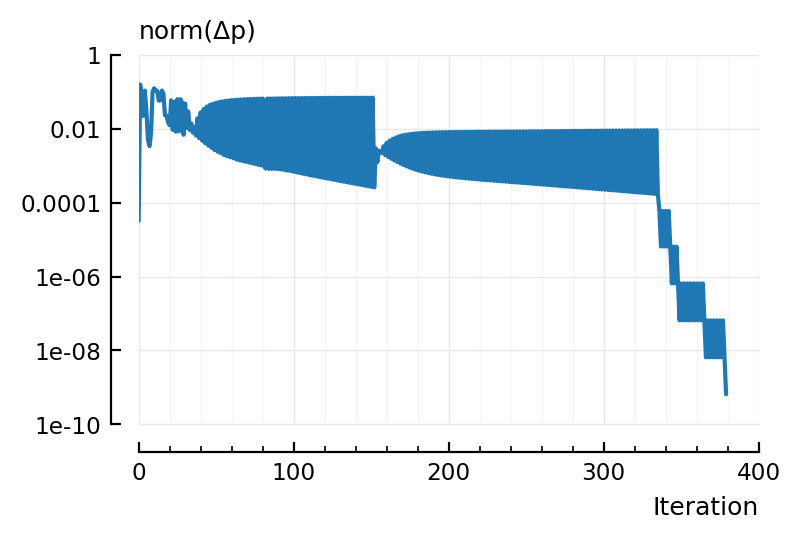

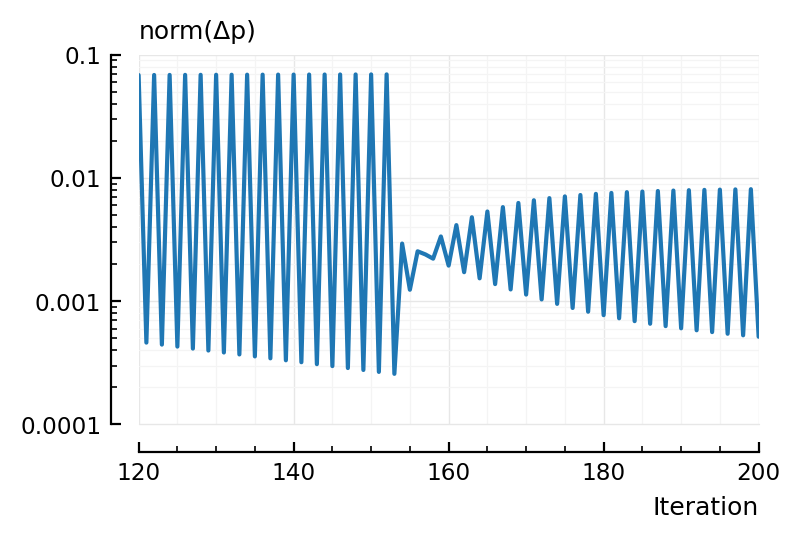

In [43]:
plot(norm.(dxs), xlabel = "Iteration", hylabel="norm(Δp)", yscale = "log");

# Zoom
plt.subplots()
sel = 120:200
plot(sel, norm.(dxs[sel]), xlabel = "Iteration", hylabel="norm(Δp)", yscale = "log");

Hm, from this, seems like we can't get away with many less iterations: the parameter changes do not get smaller until the very end.

I want to see, through an animated model plot, how the fit evolves over the procedure.
Can't do `[p0_vec .+ d for d in cumsum(dxs)]`. End result is not same.
(Not every iteration is x updated).

So I'll do it the dumb way and gradually increase `maxIter`.

PyPlot.jl animation: [thx here](https://genkuroki.github.io/documents/Jupyter/20170624%20Examples%20of%20animations%20in%20Julia%20by%20PyPlot%20and%20matplotlib.animation.html)

In [68]:
using PyCall

In [69]:
@pyimport matplotlib.animation as anim

In [138]:
PyPlot.isjulia_display[] = false
fig, ax = plt.subplots()
plotsig(centre(STA) / mV, p; ax)
tms = collect(linspace(0, 100, 1000))
y0 = 
ln, = ax.plot(tms, zeros(length(tms)))
y = copy(t);

In [139]:
function update(i)
    res = curve_fit(turbomodel!, jac_turbomodel!, t, centre(STA), p0_vec; lower, upper, inplace = true, maxIter = i)
    turbomodel!(y, t, res.param)
    ln.set_ydata(y / mV)
end

In [141]:
PyPlot.isjulia_display[] = true;  # rerun to clear out buffer :p

In [147]:
anim.writers.list()

2-element Vector{String}:
 "pillow"
 "html"

In [152]:
rcParams["animation.writer"] = "pillow";

In [ ]:
an = anim.FuncAnimation(fig, update, 10);
an.to_html5_video()

In [1]:
# This crashes julia, with "pillow".
# I'ma move to a new notebook.